### Predicting Life Expectancy in Africa
#### Using data from find.state.gov, I analyze what variables most affect average life expectancy (http://data.worldbank.org/indicator/SP.DYN.LE00.FE.IN and http://data.worldbank.org/indicator/SP.DYN.LE00.MA.IN) in African countries. The data include percentage of surviving infants receiving a dtp vaccine (http://www.data.unicef.org/child-health/immunization.html), measles vaccine percentages (http://data.worldbank.org/indicator/SH.IMM.MEAS), literacy rates (http://data.worldbank.org/indicator/SE.ADT.1524.LT.ZS), corruption index (http://data.worldbank.org/data-catalog/worldwide-governance-indicators), available dietary energy (http://www.fao.org/economic/ess/ess-fs/ess-fadata/en/), conflict rating (http://find.state.gov/visualize?id=123), sanitation facilities (http://data.worldbank.org/indicator/SH.STA.ACSN), economic freedom (http://www.heritage.org/index/explore?view=by-region-country-year) and cell phone service (http://data.worldbank.org/indicator/IT.CEL.SETS). 

### Insights: By looking at the Pearson correlation between the interpolated 2014 data and life expectancy, sanitation, corruption and vaccination rates are the most important variables. Using a gradient boosting regressor I find that I can predict life expectancy within +/- 6 years with this data, and the regression model also supports sanitation, corruption and vaccination as the most important variables.

In [22]:
import numpy
import seaborn as sns
import pandas as pd
import matplotlib
from matplotlib import *
%matplotlib inline

In [2]:
life_exp_data = pd.read_csv("data/africa-mflifeexpectancy.csv")
dp3_vacc_data = pd.read_csv("data/africa-dtpvaccine.csv")
ms_vacc_data = pd.read_csv("data/africa-measlesvaccine.csv")
lit_data = pd.read_csv("data/africa-literacy.csv")
corrupt_data = pd.read_csv("data/africa-corruption.csv")
food_energy_data = pd.read_csv("data/africa-dietenergy.csv")
conflict_data = pd.read_csv("data/africa-conflicthistory.csv")
sanit_data = pd.read_csv("data/africa-sanitation.csv")
econ_free_data = pd.read_csv("data/africa-economicfreedom.csv")
cell_phone_data = pd.read_csv("data/africa-cellservice.csv")

Average Life Expectancy 49


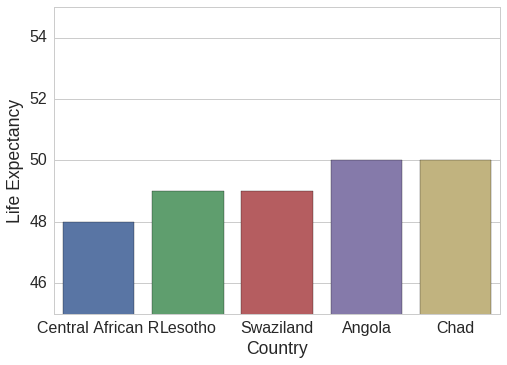

In [3]:
f_bool = (life_exp_data['Indicator']=='Life expectancy at birth female') & (life_exp_data['Year']==2014)
m_bool = (life_exp_data['Indicator']=='Life expectancy at birth male') & (life_exp_data['Year']==2014)
le_country = [unicode(i,"utf-8") for i in life_exp_data['Country'][m_bool]]
le_value = map(int,life_exp_data['Value'][m_bool])
le_zip = zip(le_value,le_country)
le_zip.sort()
low_zip_country = [i[1][:17] for i in le_zip[:5]]
low_zip_value = [i[0] for i in le_zip[:5]]
high_zip_country = [i[1][:17] for i in le_zip[-5:]]
high_zip_value = [i[0] for i in le_zip[-5:]]
sns.set(style = 'whitegrid',font_scale=1.6)
ax1 = sns.barplot(x=low_zip_country,y=low_zip_value)
ax1.set_ylim(45,55)
ax1.set_ylabel('Life Expectancy')
ax1.set_xlabel('Country')
print 'Average Life Expectancy',sum(low_zip_value)/len(low_zip_value)

Average Life Expectancy 71


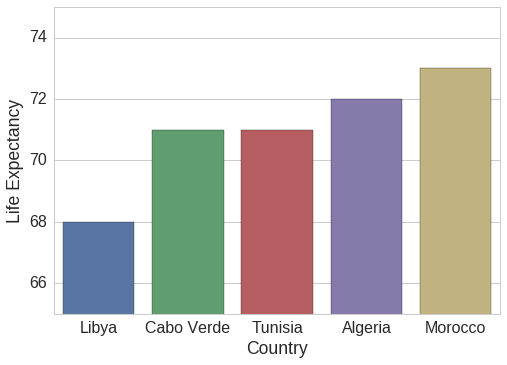

In [4]:
sns.set(style = 'whitegrid',font_scale=1.6)
ax2 = sns.barplot(x=high_zip_country,y=high_zip_value)
ax2.set_ylim(65,75)
ax2.set_ylabel('Life Expectancy')
ax2.set_xlabel('Country')
print 'Average Life Expectancy',sum(high_zip_value)/len(high_zip_value)

In [5]:
countries = ms_vacc_data['Country'].unique()

In [6]:
print 'LE',life_exp_data['Year'].unique(),'DP3',dp3_vacc_data['Year'].unique(),'Meas', ms_vacc_data['Year'].unique(), \
  'Lit',lit_data['Year'].unique(),'Corr',corrupt_data['Year'].unique(),'FE',food_energy_data['Year'].unique(), \
  'Conf',conflict_data['Year'].unique(),'San',sanit_data['Year'].unique(),'EF',econ_free_data['Year'].unique(), \
  'Cell',cell_phone_data['Year'].unique()

LE [1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014] DP3 [2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013] Meas [1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014] Lit [1990 1991 1992 1993 1994 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013] Corr [1996 1998 2000 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014] FE [1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016] Conf [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014] San [1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015] EF [1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 

In [7]:
years = corrupt_data['Year'].unique()

In [8]:
def norm_year_count(in_data,n_countries,n_years):
  in_data2 = pd.pivot_table(in_data,values='Value', index=['Country'],columns=['Year'])
  in_data2 = in_data2.reindex(n_countries)
  in_data2 = in_data2.transpose()
  in_data2 = in_data2.reindex(n_years)  
  in_data2 = in_data2.apply(pd.Series.interpolate)
  in_data2 = in_data2.transpose()
  return in_data2

In [9]:
life_exp_data2 = norm_year_count(life_exp_data,countries,years)
dp3_vacc_data2 = norm_year_count(dp3_vacc_data,countries,years)
ms_vacc_data2 = norm_year_count(ms_vacc_data,countries,years)
lit_data2 = norm_year_count(lit_data,countries,years)
corrupt_data2 = norm_year_count(corrupt_data,countries,years)
food_energy_data2 = norm_year_count(food_energy_data,countries,years)
conflict_data2 = norm_year_count(conflict_data,countries,years)
sanit_data2 = norm_year_count(sanit_data,countries,years)
econ_free_data2 = norm_year_count(econ_free_data,countries,years)
cell_phone_data2 = norm_year_count(cell_phone_data,countries,years)

In [10]:
life_exp_2014 = life_exp_data2[2014]
life_exp_2014.name="life_expectancy"
dp3_vacc_2014 = dp3_vacc_data2[2014]
dp3_vacc_2014.name='dtp_vaccine'
ms_vacc_2014 = ms_vacc_data2[2014]
ms_vacc_2014.name='measles_vaccine'
lit_2014 = lit_data2[2014]
lit_2014.name='literacy'
corrupt_2014 = corrupt_data2[2014]
corrupt_2014.name='corruption'
food_energy_2014 = food_energy_data2[2014]
food_energy_2014.name='food_energy'
conflict_2014 = conflict_data2[2014]
conflict_2014.name='conflict'
sanit_2014 = sanit_data2[2014]
sanit_2014.name='sanitation'
econ_free_2014 = econ_free_data2[2014]
econ_free_2014.name='economic_freedom'
cell_phone_2014 = numpy.log(cell_phone_data2[2014])
cell_phone_2014.name='log_cellphone_service'

In [11]:
data_2014 = pd.concat([life_exp_2014,dp3_vacc_2014,ms_vacc_2014,lit_2014,corrupt_2014,food_energy_2014, 
                       conflict_2014,sanit_2014,econ_free_2014,cell_phone_2014],axis=1)

In [12]:
plot_data_2014 = data_2014.dropna()

In [13]:
from scipy import stats
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = matplotlib.pyplot.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

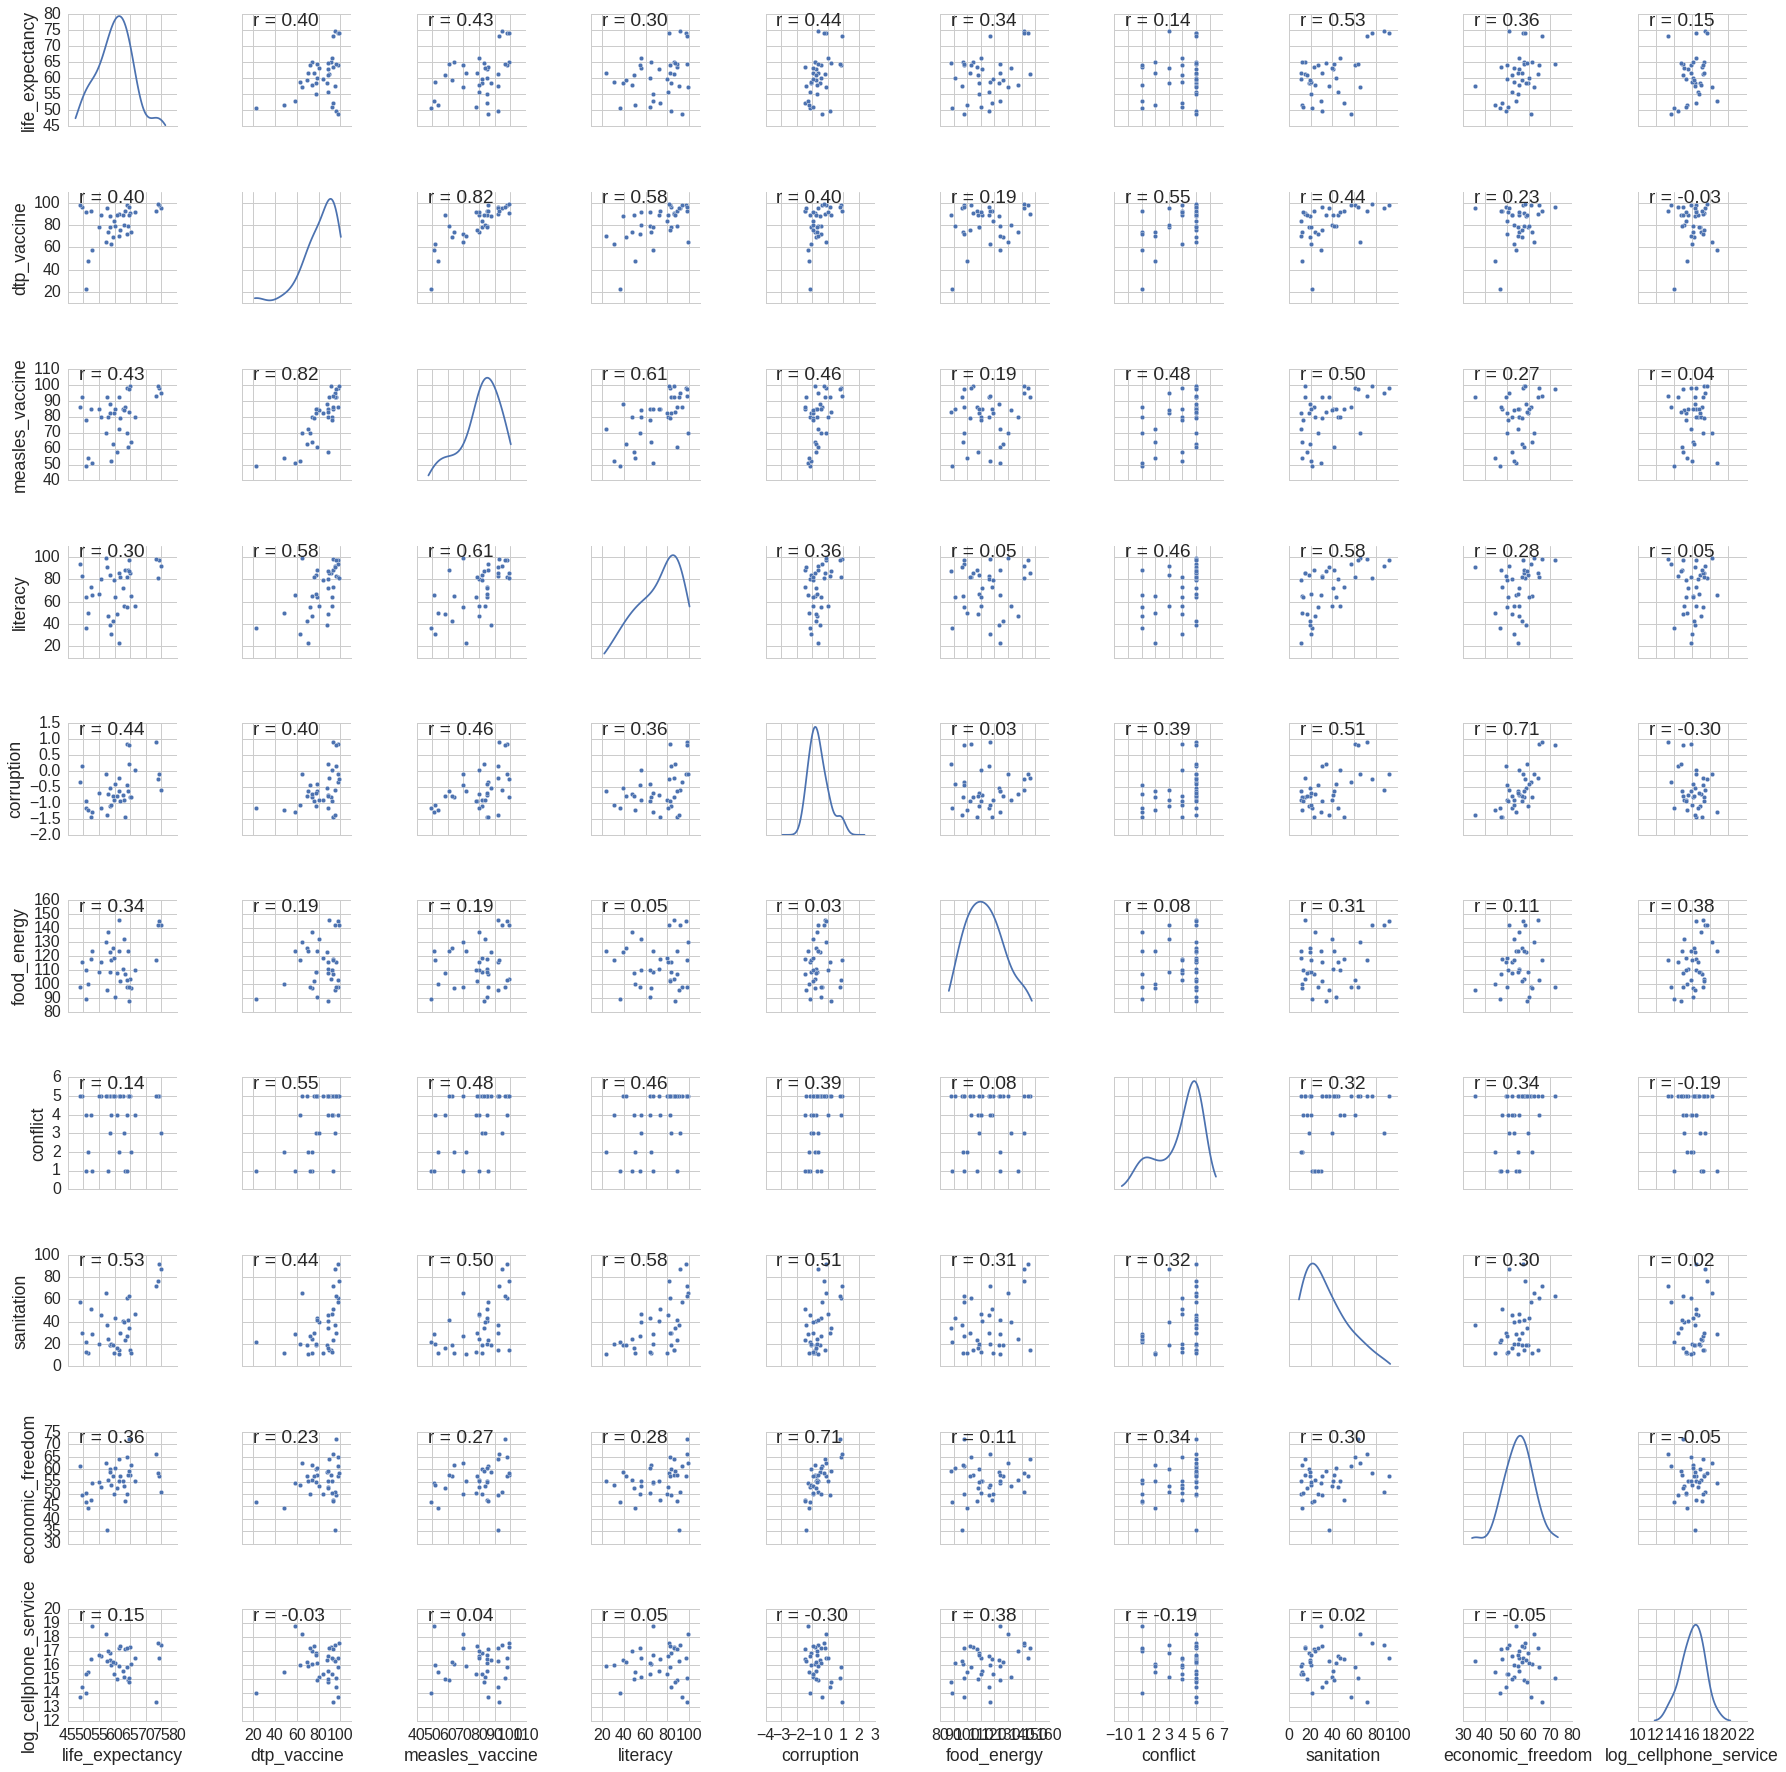

In [14]:
life_exp_correlations = sns.pairplot(plot_data_2014,diag_kind='kde')
life_exp_correlations.map_upper(corrfunc)
life_exp_correlations.map_lower(corrfunc)

In [15]:
from sklearn import preprocessing

In [16]:
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
y_data_2014 = data_2014['life_expectancy']
imp_data_2014 = imp.fit_transform(data_2014.drop(['life_expectancy'],1))
col_names = data_2014.drop(['life_expectancy'],1).keys()

In [17]:
from sklearn import cross_validation,ensemble,metrics
X_train, X_test, y_train, y_test = cross_validation.train_test_split(imp_data_2014,
                                                    y_data_2014,
                                                    test_size=0.18,
                                                    random_state=4)

In [18]:
parameters = {
              'n_estimators': 50, 
              'max_depth': 4, 
              'learning_rate': 0.1, 
              'loss': 'huber'
             }
classifier = ensemble.GradientBoostingRegressor(**parameters)

classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
mse = metrics.mean_squared_error(y_test, predictions)
print('Mean Squared Error: {:.3f}'.format(mse))

Mean Squared Error: 37.573


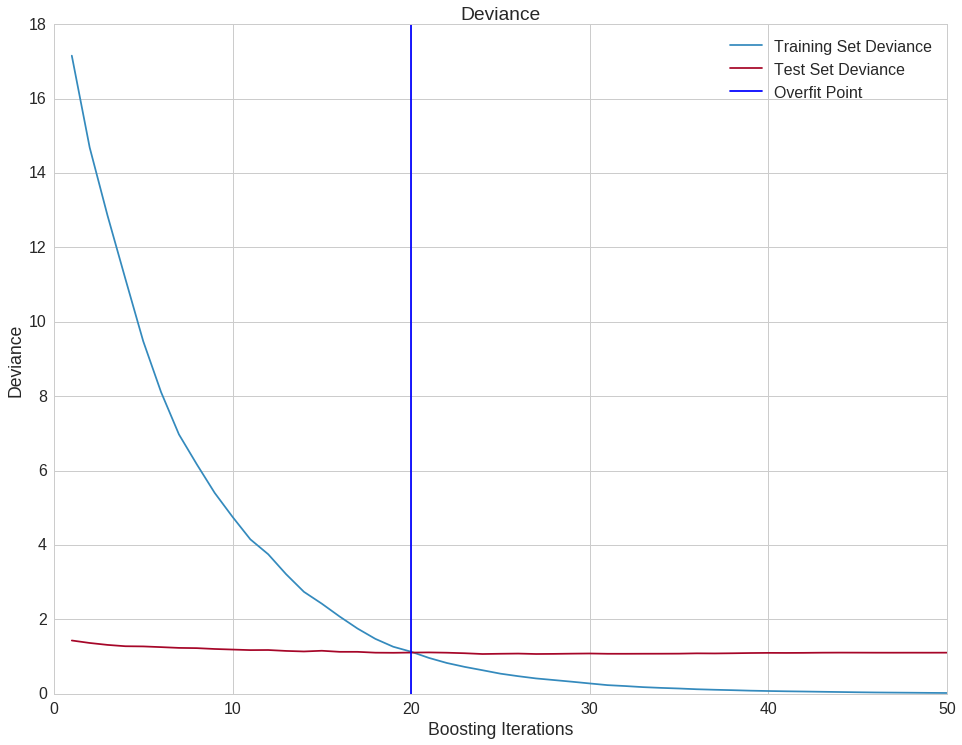

In [19]:
test_score = [classifier.loss_(y_test, y_pred) for y_pred in classifier.staged_decision_function(X_test)]

matplotlib.pyplot.figure(figsize=(16, 12))
matplotlib.pyplot.title('Deviance');
matplotlib.pyplot.plot(numpy.arange(parameters['n_estimators']) + 1, classifier.train_score_, c='#348ABD',
         label='Training Set Deviance');
matplotlib.pyplot.plot(numpy.arange(parameters['n_estimators']) + 1, test_score, c='#A60628',
         label='Test Set Deviance');
matplotlib.pyplot.axvline(20,label='Overfit Point')
matplotlib.pyplot.legend(loc='upper right');
matplotlib.pyplot.xlabel('Boosting Iterations');
matplotlib.pyplot.ylabel('Deviance');

In [20]:
parameters = {
              'n_estimators': 20, 
              'max_depth': 4, 
              'learning_rate': 0.1, 
              'loss': 'huber'
             }
classifier = ensemble.GradientBoostingRegressor(**parameters)

classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print predictions,y_test,predictions-y_test
mse = metrics.mean_squared_error(y_test, predictions)
print('Mean Squared Error: {:.3f}'.format(mse))

[ 54.23167792  62.50029078  59.44406032  71.36806627  60.61716678
  59.62521953  57.07646847  61.85569143  63.24809056  60.13716476] [ 58.745  60.265  57.985  71.785  50.89   57.53   55.52   64.98   48.915
  58.62 ] [ -4.51332208   2.23529078   1.45906032  -0.41693373   9.72716678
   2.09521953   1.55646847  -3.12430857  14.33309056   1.51716476]
Mean Squared Error: 34.660


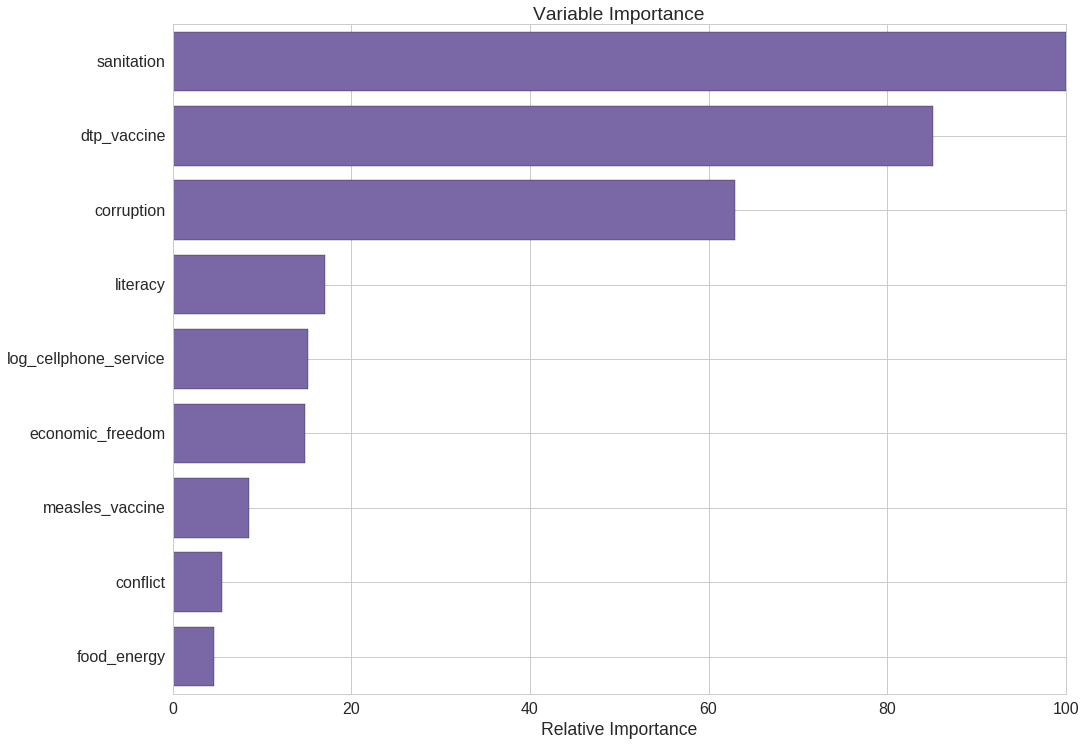

In [21]:
feature_importance = classifier.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = numpy.argsort(feature_importance)
pos = numpy.arange(sorted_idx.shape[0]) + .5
matplotlib.pyplot.figure(figsize=(16, 12))
matplotlib.pyplot.barh(pos, feature_importance[sorted_idx], align='center', color='#7A68A6')
matplotlib.pyplot.yticks(pos, numpy.asanyarray(col_names)[sorted_idx])
matplotlib.pyplot.xlabel('Relative Importance')
matplotlib.pyplot.title('Variable Importance')
matplotlib.pyplot.show()